In [17]:
import pandas as pd
import numpy as np
import os 

from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing import image
from keras.models import Model, load_model
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_colwidth', -1)

In [3]:
path = os.path.join('../../Data/')
path_images = path + 'Images/'

In [4]:
train_df = pd.read_csv(path + 'Imagenes.csv', sep = ';')
train_df.head()

,id,image
0,1060651400131,http://sgfm.elcorteingles.es/SGFM/dctm/MEDIA03/201902/07/00160651400131____1__516x640.jpg
1,1060651400180,http://sgfm.elcorteingles.es/SGFM/dctm/MEDIA03/201902/06/00160651400180____1__516x640.jpg
2,1051056400107,http://sgfm.elcorteingles.es/SGFM/dctm/MEDIA03/201902/07/00151056400115____1__516x640.jpg
3,1019350401147,http://sgfm.elcorteingles.es/SGFM/dctm/MEDIA03/201902/07/00119350401147____3__516x640.jpg
4,1019353400229,http://sgfm.elcorteingles.es/SGFM/dctm/MEDIA03/201902/07/00119353400237____2__516x640.jpg


In [5]:
train_df.shape

(204812, 2)

In [6]:
train_df['id'].loc[40000:40003]

40000    001004560011738
40001    001004560011746
40002    001004560011753
40003    001004560011761
Name: id, dtype: object

## Prepare Images

In [11]:
def append_text(idx):
    return idx + '.jpg'

In [12]:
train_df['idx'] = train_df['id'].apply(append_text)

In [13]:
def prepareImages(data, step, batch_size = 128):
    errors = []
    print("Preparing images")
    X_train = np.zeros((batch_size, 100, 100, 3))
    count = 0
    
    for fig in data['id'].loc[(step):(step + batch_size)]:
        count += 1
        try:
            #load images into images of size 100x100x3
            img = image.load_img(path_images + fig + '.jpg', target_size=(100, 100, 3))
            x = image.img_to_array(img)

            X_train[count] = x
            
        except:
            errors.append(fig)
            pass
    
    return X_train

In [14]:
def normalize(data):
    data = data / 255
    return data

## Autoencoder

In [15]:
input_img = Input(shape=(100,100,3))

#Encoder
x = Conv2D(50, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2,2), padding='same', name='ENCODER')(x)

#Decoder

#x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(50, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [16]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 50)      1400      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        14432     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 16)        4624      
_________________________________________________________________
ENCODER (MaxPooling2D)       (None, 13, 13, 16)        0         
__________

##  Train

In [118]:
BATCH_SIZE = 256
STEP_SIZE = train_df.shape[0]//BATCH_SIZE
GLOBAL_EPOCHS = 2
total = 0

print(f'Training model in {STEP_SIZE} steps..')

for epoch in range(0, GLOBAL_EPOCHS):
    
    total = 0
    print (f'==== EPOCH {epoch} ====')
    
    for STEP in range(0, STEP_SIZE):
        
        X_data = prepareImages(train_df, total, BATCH_SIZE)
        X_data = normalize(X_data)
        
        autoencoder.fit(X_data, X_data, epochs = 1, batch_size = BATCH_SIZE, 
                callbacks = None, verbose = 0, shuffle=False )
        
        total += BATCH_SIZE
        print(f'Step: {STEP}, Total: {total}')

Training model in 800 steps..
==== EPOCH 1 ====
Preparing images
Step: 1, Total: 256
Preparing images
Step: 2, Total: 512
Preparing images
Step: 3, Total: 768
Preparing images
Step: 4, Total: 1024
Preparing images
Step: 5, Total: 1280
Preparing images
Step: 6, Total: 1536
Preparing images
Step: 7, Total: 1792
Preparing images
Step: 8, Total: 2048
Preparing images
Step: 9, Total: 2304
Preparing images
Step: 10, Total: 2560
Preparing images
Step: 11, Total: 2816
Preparing images
Step: 12, Total: 3072
Preparing images
Step: 13, Total: 3328
Preparing images
Step: 14, Total: 3584
Preparing images
Step: 15, Total: 3840
Preparing images
Step: 16, Total: 4096
Preparing images
Step: 17, Total: 4352
Preparing images
Step: 18, Total: 4608
Preparing images
Step: 19, Total: 4864
Preparing images
Step: 20, Total: 5120
Preparing images
Step: 21, Total: 5376
Preparing images
Step: 22, Total: 5632
Preparing images
Step: 23, Total: 5888
Preparing images
Step: 24, Total: 6144
Preparing images
Step: 25, T

Step: 203, Total: 51968
Preparing images
Step: 204, Total: 52224
Preparing images
Step: 205, Total: 52480
Preparing images
Step: 206, Total: 52736
Preparing images
Step: 207, Total: 52992
Preparing images
Step: 208, Total: 53248
Preparing images
Step: 209, Total: 53504
Preparing images
Step: 210, Total: 53760
Preparing images
Step: 211, Total: 54016
Preparing images
Step: 212, Total: 54272
Preparing images
Step: 213, Total: 54528
Preparing images
Step: 214, Total: 54784
Preparing images
Step: 215, Total: 55040
Preparing images
Step: 216, Total: 55296
Preparing images
Step: 217, Total: 55552
Preparing images
Step: 218, Total: 55808
Preparing images
Step: 219, Total: 56064
Preparing images
Step: 220, Total: 56320
Preparing images
Step: 221, Total: 56576
Preparing images
Step: 222, Total: 56832
Preparing images
Step: 223, Total: 57088
Preparing images
Step: 224, Total: 57344
Preparing images
Step: 225, Total: 57600
Preparing images
Step: 226, Total: 57856
Preparing images
Step: 227, Total

Step: 403, Total: 103168
Preparing images
Step: 404, Total: 103424
Preparing images
Step: 405, Total: 103680
Preparing images
Step: 406, Total: 103936
Preparing images
Step: 407, Total: 104192
Preparing images
Step: 408, Total: 104448
Preparing images
Step: 409, Total: 104704
Preparing images
Step: 410, Total: 104960
Preparing images
Step: 411, Total: 105216
Preparing images
Step: 412, Total: 105472
Preparing images
Step: 413, Total: 105728
Preparing images
Step: 414, Total: 105984
Preparing images
Step: 415, Total: 106240
Preparing images
Step: 416, Total: 106496
Preparing images
Step: 417, Total: 106752
Preparing images
Step: 418, Total: 107008
Preparing images
Step: 419, Total: 107264
Preparing images
Step: 420, Total: 107520
Preparing images
Step: 421, Total: 107776
Preparing images
Step: 422, Total: 108032
Preparing images
Step: 423, Total: 108288
Preparing images
Step: 424, Total: 108544
Preparing images
Step: 425, Total: 108800
Preparing images
Step: 426, Total: 109056
Preparing

Step: 599, Total: 153344
Preparing images
Step: 600, Total: 153600
Preparing images
Step: 601, Total: 153856
Preparing images
Step: 602, Total: 154112
Preparing images
Step: 603, Total: 154368
Preparing images
Step: 604, Total: 154624
Preparing images
Step: 605, Total: 154880
Preparing images
Step: 606, Total: 155136
Preparing images
Step: 607, Total: 155392
Preparing images
Step: 608, Total: 155648
Preparing images
Step: 609, Total: 155904
Preparing images
Step: 610, Total: 156160
Preparing images
Step: 611, Total: 156416
Preparing images
Step: 612, Total: 156672
Preparing images
Step: 613, Total: 156928
Preparing images
Step: 614, Total: 157184
Preparing images
Step: 615, Total: 157440
Preparing images
Step: 616, Total: 157696
Preparing images
Step: 617, Total: 157952
Preparing images
Step: 618, Total: 158208
Preparing images
Step: 619, Total: 158464
Preparing images
Step: 620, Total: 158720
Preparing images
Step: 621, Total: 158976
Preparing images
Step: 622, Total: 159232
Preparing

Step: 795, Total: 203520
Preparing images
Step: 796, Total: 203776
Preparing images
Step: 797, Total: 204032
Preparing images
Step: 798, Total: 204288
Preparing images
Step: 799, Total: 204544


### Autoencoder

In [135]:
autoencoder.save('full_autoencoder_v1.h5')
#autoencoder = load_model('autoencoder_v2.h5')

### Encoder

In [119]:
encoder = Model(inputs=autoencoder.input, outputs = autoencoder.get_layer('ENCODER').output)

In [136]:
#encoder.save('full_encoder_v1.h5')

In [137]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 100, 100, 50)      1400      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 50, 50, 50)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 50, 50, 32)        14432     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 25, 25, 16)        4624      
_________________________________________________________________
ENCODER (MaxPooling2D)       (None, 13, 13, 16)        0         
Total para

## Visualize original image and reconstructed image

In [122]:
X_train = prepareImages(train_df, 80000, 10000)
X_train = normalize(X_train)

Preparing images


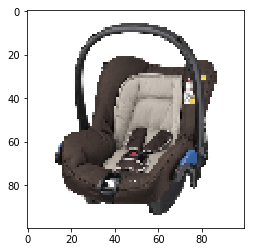

In [123]:
query = X_train[805]
plt.imshow(query)

### Encode the test images and the query image

In [124]:
X_test = X_train.copy()
X_test.shape

(10000, 100, 100, 3)

In [125]:
codes = encoder.predict(X_test)
codes.shape

(10000, 13, 13, 16)

In [126]:
query_code = encoder.predict(query.reshape(1,X_train.shape[1],X_train.shape[2],X_train.shape[3]))
query_code.shape

(1, 13, 13, 16)

### Find the closest images

In [127]:
codes = codes.reshape(-1, 13*13*16); 
print(codes.shape)
query_code = query_code.reshape(1, 13*13*16); 
print(query_code.shape)

(10000, 2704)
(1, 2704)


### Fit the KNN to the test set

In [128]:
n_neigh = 5

In [129]:
nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(codes)

In [130]:
distances, indices = nbrs.kneighbors(np.array(query_code))

In [131]:
closest_images = X_test[indices]
closest_images = closest_images.reshape(-1,100,100,3); 
print(closest_images.shape)

(5, 100, 100, 3)


## Get the closest images


In [132]:
#m = np.mean(X_val)
#sd = np.std(X_val)

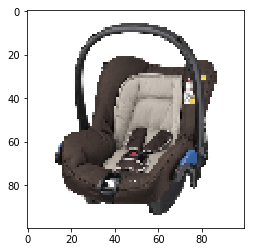

In [133]:
plt.imshow(query.reshape(100,100,3))

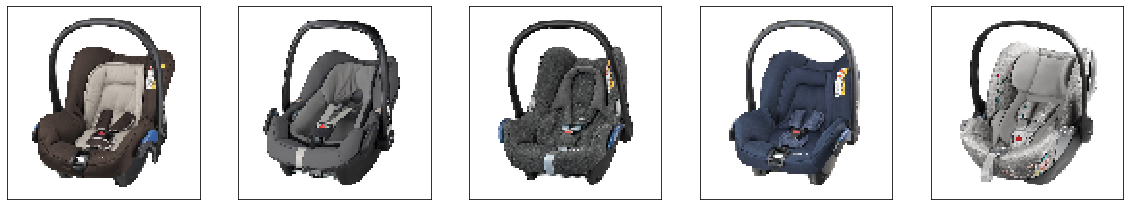

In [134]:
plt.figure(figsize=(20, 6))
for i in range(n_neigh):
    # display reconstruction
    ax = plt.subplot(1, n_neigh, i+1)
    plt.imshow(closest_images[i].reshape(100, 100,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

---